#### Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

/opt/hostedtoolcache/Python/3.12.8/x64/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 26, 1, 13, 31, 364951)

#### Connect to Hopsworks Feature Store

In [3]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 


2025-01-26 01:13:31,373 INFO: Initializing external client


2025-01-26 01:13:31,374 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-01-26 01:13:31,944 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207502


#### Feature View Retrieval


In [4]:
feature_view = fs.get_feature_view(
    name='accidents_fv',
    version=1,
)

#### Download the model from Model Registry

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="accident_model",
    version=4,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.3360655E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Get Weather Forecast Features with Feature View


In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week
0,2025-01-27 00:00:00+00:00,-0.30,0.0,10.829958,158.552200,Stockholm,0
1,2025-01-28 00:00:00+00:00,4.60,0.0,10.948973,152.592514,Stockholm,1
2,2025-01-29 00:00:00+00:00,5.30,0.0,12.434340,202.109497,Stockholm,2
3,2025-01-30 00:00:00+00:00,5.35,0.0,17.373497,264.053223,Stockholm,3
4,2025-01-31 00:00:00+00:00,1.60,0.0,15.391840,280.784241,Stockholm,4
5,2025-02-01 00:00:00+00:00,2.00,0.0,18.218275,307.775757,Stockholm,5
6,2025-02-02 00:00:00+00:00,6.25,0.1,20.063339,260.706757,Stockholm,6
7,2025-02-03 00:00:00+00:00,10.90,0.0,24.149532,280.304779,Stockholm,0


#### Making the predictions

In [8]:
batch_data['predicted_accidents'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'day_of_week']])
batch_data.sort_values(by='date', inplace=True)

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week,predicted_accidents
0,2025-01-27 00:00:00+00:00,-0.30,0.0,10.829958,158.552200,Stockholm,0,1.862858
1,2025-01-28 00:00:00+00:00,4.60,0.0,10.948973,152.592514,Stockholm,1,1.254942
2,2025-01-29 00:00:00+00:00,5.30,0.0,12.434340,202.109497,Stockholm,2,0.886886
3,2025-01-30 00:00:00+00:00,5.35,0.0,17.373497,264.053223,Stockholm,3,0.901502
4,2025-01-31 00:00:00+00:00,1.60,0.0,15.391840,280.784241,Stockholm,4,3.002661
5,2025-02-01 00:00:00+00:00,2.00,0.0,18.218275,307.775757,Stockholm,5,2.659717
6,2025-02-02 00:00:00+00:00,6.25,0.1,20.063339,260.706757,Stockholm,6,3.172765
7,2025-02-03 00:00:00+00:00,10.90,0.0,24.149532,280.304779,Stockholm,0,2.241049


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         8 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          8 non-null      float32                
 2   precipitation_sum            8 non-null      float32                
 3   wind_speed_10m_max           8 non-null      float32                
 4   wind_direction_10m_dominant  8 non-null      float32                
 5   city                         8 non-null      object                 
 6   day_of_week                  8 non-null      int32                  
 7   predicted_accidents          8 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), int32(1), object(1)
memory usage: 452.0+ bytes


#### Saving the predictions (for monitoring) to a Feature Group

In [10]:
batch_data['city'] = "Stockholm"
batch_data['country'] = "Sweden"
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week,predicted_accidents,country,days_before_forecast_day
0,2025-01-27 00:00:00+00:00,-0.30,0.0,10.829958,158.552200,Stockholm,0,1.862858,Sweden,1
1,2025-01-28 00:00:00+00:00,4.60,0.0,10.948973,152.592514,Stockholm,1,1.254942,Sweden,2
2,2025-01-29 00:00:00+00:00,5.30,0.0,12.434340,202.109497,Stockholm,2,0.886886,Sweden,3
3,2025-01-30 00:00:00+00:00,5.35,0.0,17.373497,264.053223,Stockholm,3,0.901502,Sweden,4
4,2025-01-31 00:00:00+00:00,1.60,0.0,15.391840,280.784241,Stockholm,4,3.002661,Sweden,5
5,2025-02-01 00:00:00+00:00,2.00,0.0,18.218275,307.775757,Stockholm,5,2.659717,Sweden,6
6,2025-02-02 00:00:00+00:00,6.25,0.1,20.063339,260.706757,Stockholm,6,3.172765,Sweden,7
7,2025-02-03 00:00:00+00:00,10.90,0.0,24.149532,280.304779,Stockholm,0,2.241049,Sweden,8


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         8 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          8 non-null      float32                
 2   precipitation_sum            8 non-null      float32                
 3   wind_speed_10m_max           8 non-null      float32                
 4   wind_direction_10m_dominant  8 non-null      float32                
 5   city                         8 non-null      object                 
 6   day_of_week                  8 non-null      int32                  
 7   predicted_accidents          8 non-null      float32                
 8   country                      8 non-null      object                 
 9   days_before_forecast_day     8 non-null      int64                  
dtypes: dat

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

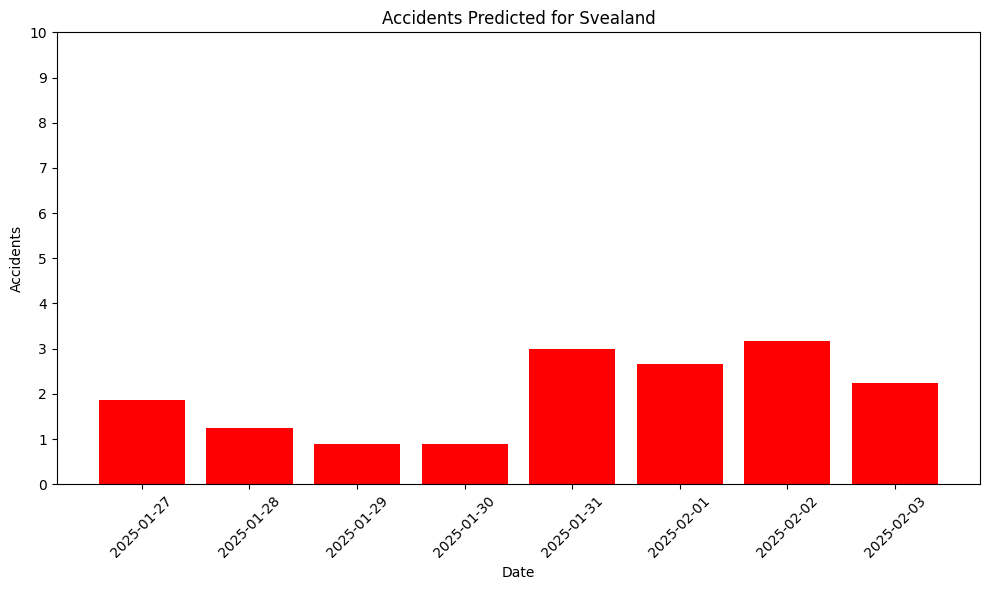

In [12]:
import os
from functions import util
file_path = "../data/forecast.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_forecast("Svealand", batch_data, file_path=file_path)
plt.show()

In [13]:
import os
from functions import util
file_path = "../data/forecast_table.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_table("Svealand", batch_data, file_path=file_path)
plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='accidents_predictions',
    description='Accidents prediction monitoring',
    version=1,
    primary_key=['city','date','days_before_forecast_day'],
    event_time="date"
)


In [15]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 37.50% |███▊      | Rows 3/8 | Elapsed Time: 00:01 | Remaining Time: 00:01

Uploading Dataframe: 100.00% |██████████| Rows 8/8 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: accidents_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207502/jobs/named/accidents_predictions_1_offline_fg_materialization/executions


2025-01-26 01:13:49,030 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED


2025-01-26 01:13:52,210 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-01-26 01:15:49,455 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-01-26 01:15:49,517 INFO: Waiting for log aggregation to finish.


2025-01-26 01:16:07,620 INFO: Execution finished successfully.


(Job('accidents_predictions_1_offline_fg_materialization', 'SPARK'), None)